<a href="https://www.kaggle.com/code/carterung/arcface?scriptVersionId=127381612" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as model
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import tarfile
import shutil
from torch.nn import DataParallel
from pathlib import Path
!pip install torchsummary
!pip install retina-face
!pip install deepface
import cv2
from torchsummary import summary
import os
from retinaface import RetinaFace
import torch.nn as nn
from PIL import Image
import math
import time


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
     ━━━━━━━

In [2]:
# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [3]:
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [4]:
class ArcFaceLoss(torch.nn.Module):
    """Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin

            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        torch.nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, feature, label= None):
        # Normalize embeddings and weights
        feature = F.normalize(feature)
        weights = F.normalize(self.weight)

        # Compute the logit
        cos_theta = F.linear(feature, weights)
        
        if (label is None):
            return cos_theta

        # Find the angle between the weight and feature
        theta = torch.acos(cos_theta)

        # Add angular margin penalty
        marginal_target_logit = torch.cos(theta + self.m)
        
        marginal_target_logit = torch.where(cos_theta > self.th, marginal_target_logit, cos_theta - self.mm)

        # One-hot encoding
        one_hot = torch.zeros(cos_theta.size(), device=device)
       # one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        # Compute class wise similarity score through element wise multiplication of one_hot ground truth and the marginal target logit
        score = (one_hot * marginal_target_logit) + ((1.0 - one_hot) * cos_theta)
        #score = torch.mul(marginal_target_logit, one_hot)

        # Rescale to s
        score *= self.s

        return score


In [5]:
# transform into tensors
transform_train = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [6]:
# Define the source and destination directories
src_dir = "/kaggle/input/lfw-cropped-faces/lfw_cut"
dst_dir = "/kaggle/working/lfw_cut"

# Remove the destination directory if it already exists
if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)

# Use shutil to copy the source directory to the destination directory
shutil.copytree(src_dir, dst_dir)

'/kaggle/working/lfw_cut'

In [7]:
# Set the root directory path where the subdirectories are located
root_directory_path = "/kaggle/working/lfw_cut"
count = 0
# Loop through all subdirectories and delete the files containing 'ipynb_checkpoints'
for subdir, dirs, files in os.walk(root_directory_path, topdown= True):
    files.sort()
    dirs.sort()
    if (count == 0):
        num_classes_LFW = len(dirs)
    count += 1
    for file in files:
        if "checkpoints" in subdir:
            shutil.rmtree(subdir)
       # print(subdir)
print(num_classes_LFW)

5715


In [8]:
# Set your dataset directory path here
dataset_dir = "/kaggle/working/lfw_cut/"

# Set your train, val, and test ratios here
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Get the list of subdirectories in the dataset directory
subdirs = [name for name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, name))]

# Shuffle the list of subdirectories
random.shuffle(subdirs)

# Split the subdirectories into train, val, and test sets
train_subdirs = subdirs[:int(len(subdirs) * train_ratio)]
val_subdirs = subdirs[int(len(subdirs) * train_ratio):int(len(subdirs) * (train_ratio + val_ratio))]
test_subdirs = subdirs[int(len(subdirs) * (train_ratio + val_ratio)):]

# Create the train, val, and test directories
train_dir = os.path.join(dataset_dir, "train")
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(dataset_dir, "val")
os.makedirs(val_dir, exist_ok=True)
test_dir = os.path.join(dataset_dir, "test")
os.makedirs(test_dir, exist_ok=True)

# Move the images from the subdirectories to the train, val, and test directories
for subdir in train_subdirs:
    src_dir = os.path.join(dataset_dir, subdir)
    dst_dir = os.path.join(train_dir, subdir)
    os.makedirs(dst_dir, exist_ok=True)
    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dst_path = os.path.join(dst_dir, img_file)
        shutil.copy(src_path, dst_path)

for subdir in val_subdirs:
    src_dir = os.path.join(dataset_dir, subdir)
    dst_dir = os.path.join(val_dir, subdir)
    os.makedirs(dst_dir, exist_ok=True)
    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dst_path = os.path.join(dst_dir, img_file)
        shutil.copy(src_path, dst_path)

for subdir in test_subdirs:
    src_dir = os.path.join(dataset_dir, subdir)
    dst_dir = os.path.join(test_dir, subdir)
    os.makedirs(dst_dir, exist_ok=True)
    for img_file in os.listdir(src_dir):
        src_path = os.path.join(src_dir, img_file)
        dst_path = os.path.join(dst_dir, img_file)
        shutil.copy(src_path, dst_path)

In [9]:
class LFWDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform= None):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self.transform = transform
        for label, subdir in enumerate(os.listdir(root_dir)):
            subdir_path = os.path.join(root_dir, subdir)
            if not os.path.isdir(subdir_path):
                continue
            for img_file in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_file)
                self.data.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if (self.transform is not None):
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [10]:
lfwdataset_train = LFWDataset(root_dir = "/kaggle/working/lfw_cut/train", transform=transform_train)
lfwdataset_test = LFWDataset(root_dir = "/kaggle/working/lfw_cut/test", transform=transform)
lfwdataset_val = LFWDataset(root_dir = "/kaggle/working/lfw_cut/val", transform=transform)
lfw_pairs_test = torchvision.datasets.LFWPairs(root = "kaggle/output/lfwpeople", split= "test", transform= transform, download=True)

  0%|          | 0/243346528 [00:00<?, ?it/s]

Extracting kaggle/output/lfwpeople/lfw-py/lfw-funneled.tgz to kaggle/output/lfwpeople/lfw-py


  0%|          | 0/26002 [00:00<?, ?it/s]

In [11]:
data_loader_valid = DataLoader(lfwdataset_val, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= True)
data_loader_train = DataLoader(lfwdataset_train, batch_size= 32, shuffle= True, num_workers=0, collate_fn= None, pin_memory= True)
data_loader_test = DataLoader(lfwdataset_test, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= False)

#num_classes_LFW = 5749

#num_classes_LFW = len(set(lfwdataset_val.labels))

print(len(set(lfwdataset_train.labels)))
print(len(set(lfwdataset_test.labels)))
print(len(set(lfwdataset_val.labels)))

4572
572
571


In [12]:
# # Define a custom LFWPeople dataset with RetinaFace preprocessing
# class LFWRetinaFace(torchvision.datasets.LFWPeople):
#     def _loader(self, path):
#         with open(path, "rb") as f: 
#             img1 = RetinaFace.extract_faces(path, align= True)
#             if (len(img1) == 0):
#                 return img
#             img1 = Image.fromarray(img1[0])
#             img1 = img1.convert("RGB")
#             return img1
            

In [13]:
# import shutil
# shutil.rmtree('kaggle/output/lfwpeople')
# # Make the LFW test and train datasets and put in dataloader for batching
# lfwdataset_train = LFWRetinaFace(root = "kaggle/output/lfwpeople", split= "train", transform=transform_train, download=True)
# lfwdataset_test = LFWRetinaFace(root = "kaggle/output/lfwpeople", split= "test", transform=transform, download=True)
# lfwdataset_val = LFWRetinaFace(root = "kaggle/output/lfwpeople", split= "10fold", transform=transform, download=True)
# lfw_pairs_test = torchvision.datasets.LFWPairs(root = "kaggle/output/lfwpeople", split= "test", transform= transform, download=True)

# data_loader_valid = DataLoader(lfwdataset_val, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= True)
# data_loader_train = DataLoader(lfwdataset_train, batch_size= 32, shuffle= True, num_workers=0, collate_fn= None, pin_memory= True)
# data_loader_test = DataLoader(lfwdataset_test, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= False)

# #num_classes_LFW = 5749

# num_classes_LFW = len(set(lfwdataset_val.targets))

# print(len(set(lfwdataset_train.targets)))
# print(len(set(lfwdataset_test.targets)))
# print(len(set(lfwdataset_val.targets)))

In [14]:
# import shutil
# shutil.rmtree('/kaggle/working/kaggle/input')
# # Make the LFW test and train datasets and put in dataloader for batching
# lfwdataset_train = torchvision.datasets.LFWPeople(root = "/kaggle/working/kaggle/input", split= "train", transform=transform_train, download=True)
# lfwdataset_test = torchvision.datasets.LFWPeople(root = "/kaggle/working/kaggle/input", split= "test", transform=transform, download=True)
# lfwdataset_val = torchvision.datasets.LFWPeople(root = "/kaggle/working/kaggle/input", split= "10fold", transform=transform, download=True)
# lfw_pairs_test = torchvision.datasets.LFWPairs(root = "/kaggle/working/kaggle/input", split= "test", transform= transform, download= True)


In [15]:
# # Import into DataLoader
# data_loader_valid = DataLoader(lfwdataset_val, batch_size= 32, shuffle= False, num_workers=2, collate_fn= None, pin_memory= True)
# data_loader_train = DataLoader(lfwdataset_train, batch_size= 32, shuffle= True, num_workers=2, collate_fn= None, pin_memory= True)
# data_loader_test = DataLoader(lfwdataset_test, batch_size= 32, shuffle= False, num_workers=0, collate_fn= None, pin_memory= False)

# #num_classes_LFW = 5749

# num_classes_LFW = len(set(lfwdataset_val.targets))
# print(len(set(lfwdataset_train.targets)))
# print(len(set(lfwdataset_test.targets)))
# print(len(set(lfwdataset_val.targets)))

/kaggle/working/lfw_cut/test/Werner_Schlager/Werner_Schlager_0001.jpg


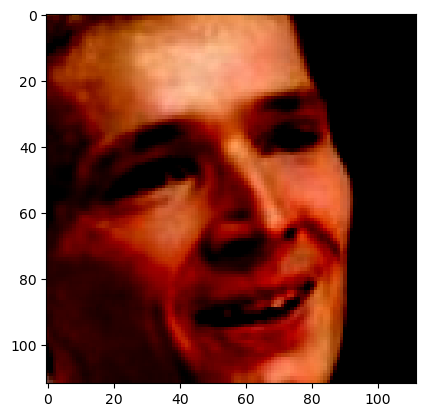

/kaggle/working/lfw_cut/test/Caio_Blat/Caio_Blat_0001.jpg


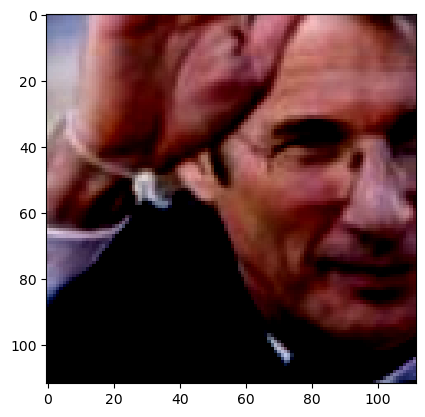

/kaggle/working/lfw_cut/test/Nathirah_Hussein/Nathirah_Hussein_0001.jpg


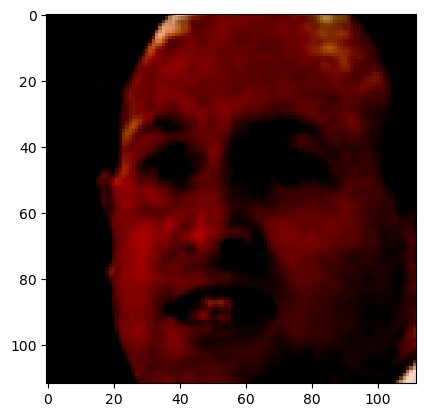

/kaggle/working/lfw_cut/test/Lawrence_MacAulay/Lawrence_MacAulay_0001.jpg


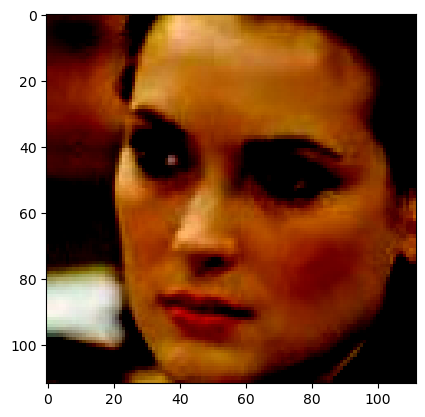

/kaggle/working/lfw_cut/test/Sean_OKeefe/Sean_OKeefe_0004.jpg


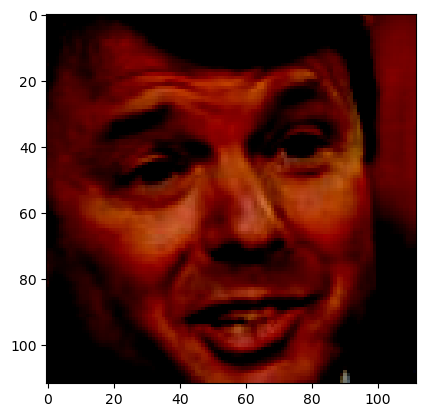

In [16]:
iterate = iter(data_loader_test)
for i in range(5):
    images, labels = next(iterate)
    print(lfwdataset_test.data[labels[0].numpy()])
    # # Display the first image in the batch
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()

In [17]:
using_ckpt = False
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class IBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1):
        super(IBasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.bn1 = nn.BatchNorm2d(inplanes, eps=1e-05,)
        self.conv1 = conv3x3(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.prelu = nn.PReLU(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes, eps=1e-05,)
        self.downsample = downsample
        self.stride = stride

    def forward_impl(self, x):
        identity = x
        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return out        

    def forward(self, x):
        if self.training and using_ckpt:
            return checkpoint(self.forward_impl, x)
        else:
            return self.forward_impl(x)


class IResNet(nn.Module):
    fc_scale = 7 * 7
    def __init__(self,
                 block, layers, dropout=0.5, num_features=512, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None, fp16=False):
        super(IResNet, self).__init__()
        self.extra_gflops = 0.0
        self.fp16 = fp16
        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes, eps=1e-05)
        self.prelu = nn.PReLU(self.inplanes)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.bn2 = nn.BatchNorm2d(512 * block.expansion, eps=1e-05,)
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(512 * block.expansion * self.fc_scale, num_features)
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        nn.init.constant_(self.features.weight, 1.0)
        self.features.weight.requires_grad = False

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.1)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, IBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion, eps=1e-05, ),
            )
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        with torch.cuda.amp.autocast(self.fp16):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.prelu(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.bn2(x)
            x = torch.flatten(x, 1)
            x = self.dropout(x)
        x = self.fc(x.float() if self.fp16 else x)
        x = self.features(x)
        return x


def _iresnet(arch, block, layers, pretrained, progress, **kwargs):
    model = IResNet(block, layers, **kwargs)
    if pretrained:
        raise ValueError()
    return model


def iresnet18(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet18', IBasicBlock, [2, 2, 2, 2], pretrained,
                    progress, **kwargs)


def iresnet34(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet34', IBasicBlock, [3, 4, 6, 3], pretrained,
                    progress, **kwargs)


def iresnet50(pretrained=False, progress=True, **kwargs):
    return _iresnet('iresnet50', IBasicBlock, [3, 4, 14, 3], pretrained,
                    progress, **kwargs)

In [18]:
#Implemenet CNN Baacosh_ckbone
Path_resnet = Path('/kaggle/input/arcface-weights/resnet50_weights3.pth') 
# if (Path_resnet.is_file()):
#     models = model.resnet50()
#     # Freeze All CNN Layers (Stop all learning in all layers)
#     for param in models.parameters():
#         param.requires_grad = False

#     # Change the final layer (unfreeze fc layer)
#     models.avgpool = torch.nn.Identity()
#     models.fc = torch.nn.Sequential(
#     torch.nn.BatchNorm1d(num_features= 100352),
#     torch.nn.Dropout(p=0.5),
#     torch.nn.Linear(in_features= 100352, out_features=512, bias=True),
#     torch.nn.BatchNorm1d(num_features=512)
#     )
#     models.fc.requires_grad = True
#     models = DataParallel(models)
#     models.load_state_dict(torch.load('/kaggle/working/resnet50_weights.pth'))
#     print(models.state_dict())
# else:
# weights = model.ResNet50_Weights.DEFAULT
# models = model.resnet50(weights = weights)


# #Freeze All CNN Layers (Stop all learning in all layers)
# for param in models.parameters():
#     param.requires_grad = False

# # Change the final layer (unfreeze fc layer)
# models.avgpool = torch.nn.Identity()
# models.fc = torch.nn.Sequential(
# torch.nn.BatchNorm1d(num_features= 32768, track_running_stats= True),
# torch.nn.Dropout(p=0.5),
# torch.nn.Linear(in_features= 32768, out_features=512, bias=True),
# torch.nn.BatchNorm1d(num_features=512, track_running_stats= True)
# )
# if (Path_resnet.is_file()):
#     models = iresnet50()
#     models.fc.requires_grad = True
#     models = DataParallel(models)
#     models.load_state_dict(torch.load('/kaggle/input/arcface-weights/resnet50_weights3.pth'))
# else:
models = iresnet50()
models.fc.requires_grad = True
#models = DataParallel(models)

models.to(device)
models

IResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=64)
  (layer1): Sequential(
    (0): IBasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): IBas

In [19]:
Path_arcface = Path('/kaggle/input/arcface-weights/arcface_weights3.pth')
# if (Path_arcface.is_file()):
#     metric_fc = ArcFaceLoss(512, num_classes_LFW, 64.0, 0.5)
#     metric_fc = DataParallel(metric_fc)
#     metric_fc.requires_grad = True
#     metric_fc.load_state_dict(torch.load('/kaggle/input/arcface-weights/arcface_weights3.pth'))
# else:
metric_fc = ArcFaceLoss(512, num_classes_LFW, 64.0, 0.5)
metric_fc = DataParallel(metric_fc)
metric_fc.requires_grad = True

metric_fc.to(device)
print(metric_fc.state_dict())
# Analyze model parameters and layers
#summary(models, (3, 112, 112))

OrderedDict([('module.weight', tensor([[-0.0262, -0.0193, -0.0061,  ...,  0.0257,  0.0187,  0.0071],
        [ 0.0222, -0.0075,  0.0203,  ..., -0.0068,  0.0004, -0.0180],
        [-0.0138, -0.0119,  0.0027,  ..., -0.0268,  0.0307,  0.0179],
        ...,
        [-0.0096, -0.0115, -0.0134,  ...,  0.0078, -0.0103, -0.0168],
        [-0.0057,  0.0284,  0.0221,  ...,  0.0183,  0.0041,  0.0069],
        [ 0.0252, -0.0215, -0.0287,  ..., -0.0016, -0.0163,  0.0184]],
       device='cuda:0'))])


In [20]:
# Focal loss is an improved method of Cross Entropy that can focus on scaling the harder cases then the easier cases
#Loss = torch.nn.CrossEntropyLoss().to(device)
Loss = FocalLoss(gamma= 2).to(device)
Loss.requires_grad = True

In [21]:
# Setup Optimizer and Scheduler
optimizer = torch.optim.SGD([{'params': models.parameters()},
                              {'params': metric_fc.parameters()}],
                              lr = 1e-1, weight_decay= 5e-4, momentum= 0.9)  # Can use Adam or SGD
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones= [30, 80, 120, 170], gamma= 0.1)



In [22]:
# Train Model with Provided ArcFace 
start = time.time()
history = []
best_acc = 0.0


for epoch in range(200):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch + 1, 10))

    # Set model to train mode
    models.train()

  #  Step through scheduler
    scheduler.step()

    train_loss = 0.0
    train_acc = 0.0 

    valid_loss = 0.0
    valid_acc = 0.0


    for i, (images, labels) in enumerate(data_loader_train):
        
        # Put tensors into device to run CUDA
        images, labels = images.to(device), labels.to(device)
        
        # Run Resnet50 on images to compute the embedding of size 512
        embeddings = models(images)

        # Push this embedding to our Arcface fc output layer
        output = metric_fc(embeddings, labels)
        
        # Calculate loss
        loss = Loss(output, labels)

        # Clean existing gradients
        optimizer.zero_grad()
        
        # Backprop the gradients
        loss.backward()

        # Update Parameters after backprop
        optimizer.step()
        

        # Accumulate loss
        train_loss += loss.item()

        # Accuracy prediction
        ret, predictions = torch.max(output.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Conver correct_counts to float then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
  
        # Compute the total accuracy in the whole batch and add to train_acc
        train_acc += acc.item()
        if (i % 100 == 0):
          #print('Predictions: {}, Truth: {}'.format(output, labels))
          #print(correct_counts)
            print('Batch #: [{:03d}/{}], Train Loss: {}, Train Accuracy: {}'
                  .format(i+1, len(data_loader_train), train_loss / (i+1), train_acc / (i + 1)))
      

    
    # Run Validation 
    with torch.no_grad():
        print("Run Validation:")
        # Set to evaluation mode
        models.eval()

        valid_loss = 0.0
        valid_acc = 0.0

        for j, (images, labels) in enumerate(data_loader_valid):
            # Put tensors into device to run CUDA
            images, labels = images.to(device), labels.to(device)

            # Run Resnet50 on images to compute the output feature
            embeddings = models(images)

            # Push this embedding to our Arcface fc output layer
            output = metric_fc(embeddings)
            
            # Calculate loss
            loss = Loss(output, labels)

            # Calculate the total loss for the batch and add it to valid_loss
            valid_loss += loss.item()

            # Accuracy prediction
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute the total accuracy in the whole batch and add to train_acc
            valid_acc += acc.item()
            if (j % 100 == 0):
                print('Validation Batch #: {:03d}, Validation Loss: {}, Validation Accuracy: {}'
              .format(j+1, valid_loss / (j + 1), valid_acc / (j + 1)))
    history.append({'loss': train_loss / len(data_loader_train), 'acc': train_acc / len(data_loader_train), 'val_loss': valid_loss / len(data_loader_valid), 'val_acc': valid_acc / len(data_loader_valid)})
   

Epoch: 1/10
Batch #: [001/339], Train Loss: 43.3575439453125, Train Accuracy: 0.0
Batch #: [101/339], Train Loss: 61.529472313304936, Train Accuracy: 0.0
Batch #: [201/339], Train Loss: 59.91781864830511, Train Accuracy: 0.0
Batch #: [301/339], Train Loss: 58.506986725766, Train Accuracy: 0.0
Run Validation:
Validation Batch #: 001, Validation Loss: 8.63665771484375, Validation Accuracy: 0.0
Epoch: 2/10
Batch #: [001/339], Train Loss: 50.484535217285156, Train Accuracy: 0.0
Batch #: [101/339], Train Loss: 43.38328450269038, Train Accuracy: 0.0
Batch #: [201/339], Train Loss: 41.50966234349493, Train Accuracy: 0.0
Batch #: [301/339], Train Loss: 40.74584026906974, Train Accuracy: 0.0
Run Validation:
Validation Batch #: 001, Validation Loss: 8.634330749511719, Validation Accuracy: 0.0
Epoch: 3/10
Batch #: [001/339], Train Loss: 38.26194381713867, Train Accuracy: 0.0
Batch #: [101/339], Train Loss: 38.15988521764774, Train Accuracy: 0.0
Batch #: [201/339], Train Loss: 38.277387040171455, 

In [23]:
# Save Weights from metric_fc and resnet50
torch.save(models.state_dict(), '/kaggle/working/resnet50_weights2.pth')
torch.save(metric_fc.state_dict(), '/kaggle/working/arcface_weights2.pth')
print("Weights")

Weights


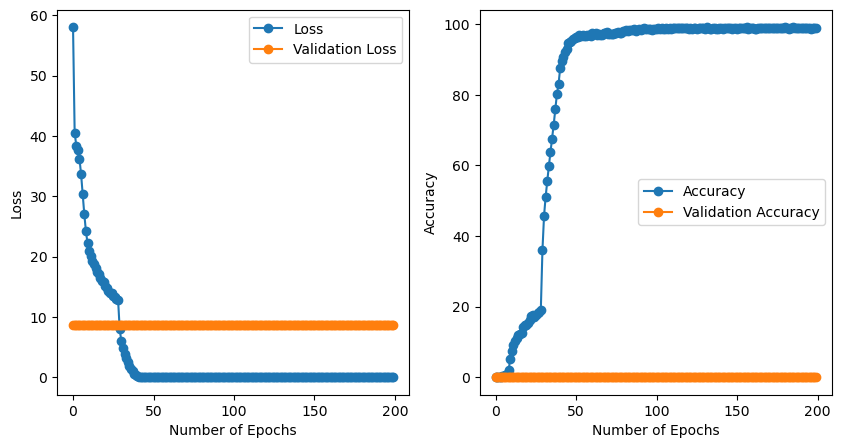

In [24]:
# Visualize the training and validation results
accuracy = [res['acc'] for res in history]
losses = [res['loss'] for res in history]
val_accuracy = [res['val_acc'] for res in history]
val_losses = [res['val_loss'] for res in history]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(losses, '-o', label = 'Loss')
ax1.plot(val_losses, '-o', label = 'Validation Loss')
ax1.set_xlabel("Number of Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend();

fig.show()

In [25]:
# Get the embedding list and label list
with torch.no_grad():
    models.eval()
    embedding_list = []
    label_list = []
    # Fill query and gallery set
    for i, (img, label) in enumerate(data_loader_test):
        img, label = img.to(device), label.to(device)
        embeddings = models(img)
        embedding_list.append(embeddings)
        label_list.append(label)

    label_list = torch.cat(label_list)
    embedding_list = torch.cat(embedding_list)
    

In [26]:
# Make class dictionary
class_dict = {}
label_list = label_list.to("cpu").numpy().tolist()
for i in range(len(label_list)):
    if (label_list[i] not in class_dict):
        class_dict[label_list[i]] = [embedding_list[i]]
    else:
        class_dict[label_list[i]].append(embedding_list[i])


In [27]:
for label in class_dict.keys():
    class_dict[label] = torch.stack(class_dict[label])

In [28]:
print(class_dict[20][0].shape)

torch.Size([512])


In [29]:
# Fill query and gallery sets
query_set = {"embedding": [],
            "label": []}
gallery_set = {"embedding": [],
            "label": []}
for label in class_dict.keys():
    if (len(class_dict[label]) > 1):
        query_set["embedding"].append(class_dict[label][0])
        query_set["label"].append(label)
        
        for j in range(1, len(class_dict[label])):
            gallery_set["embedding"].append(class_dict[label][j])
            gallery_set["label"].append(label)

In [30]:
gallery_set["embedding"] = torch.stack(gallery_set["embedding"])
label_dict = {}
for idx in range(len(gallery_set["label"])):
    label_dict[idx] = gallery_set["label"][idx]
gallery_set["label"] = label_dict
print(len(gallery_set["label"]))
print(len(query_set["embedding"]))
print(gallery_set["embedding"].shape)
print(query_set["embedding"][0].shape)

514
154
torch.Size([514, 512])
torch.Size([512])


In [31]:
# # Probe images to test against the embedding gallery
# with torch.inference_mode():
#     models.eval()

#     correct_counts1 = 0.0
#     correct_counts2 = 0.0
#     correct_counts3 = 0.0

#     for probe_idx in range(len(query_set['embedding'])):
#         probe_emb = query_set['embedding'][probe_idx]
#         probe_label = query_set['label'][probe_idx]

#         # cos_similarity = torch.matmul(probe_emb, gallery['embeddings'].transpose(0, 1))

#         cos_similarity = F.cosine_similarity(probe_emb, gallery_set['embedding'], dim= -1)
#        # print(cos_similarity)
# #         print('Cosine Sim: {}, {}'.format(probe_label, cos_similarity[probe_label]))
#         #print('probe label:{}'.format(probe_label))
#         ret, pred = torch.topk(cos_similarity, 3)
#         #print(ret, gallery_set['label'][pred[0].to("cpu").numpy().tolist()], gallery_set['label'][pred[1].to("cpu").numpy().tolist()], gallery_set['label'][pred[2].to("cpu").numpy().tolist()])
#         #print('prediction: {}, {}'.format(ret, gallery_set['label'][pred.to("cpu").numpy().tolist()]))
#         #correct_counts += torch.eq(probe_label, gallery_set['label'][pred.to("cpu").numpy().tolist()])
#       #  correct_counts += torch.sum(torch.eq(probe_label, gallery_set['label'][pred]))
#         correct_counts1 +=  gallery_set['label'][pred[0].to("cpu").numpy().tolist()] == probe_label
#         correct_counts2 +=  (gallery_set['label'][pred[0].to("cpu").numpy().tolist()] == probe_label) or (gallery_set['label'][pred[1].to("cpu").numpy().tolist()] == probe_label)
#         correct_counts3 +=  (gallery_set['label'][pred[0].to("cpu").numpy().tolist()] == probe_label) or (gallery_set['label'][pred[1].to("cpu").numpy().tolist()] == probe_label) or (gallery_set['label'][pred[2].to("cpu").numpy().tolist()] == probe_label)
# top_1 = correct_counts1 / len(query_set["embedding"])
# top_2 = correct_counts2 / len(query_set["embedding"]) 
# top_3 = correct_counts3 / len(query_set["embedding"])   
# print('top 1 accuracy: {}'.format(top_1))
# print('top 2 accuracy: {}'.format(top_2))
# print('top 3 accuracy: {}'.format(top_3))

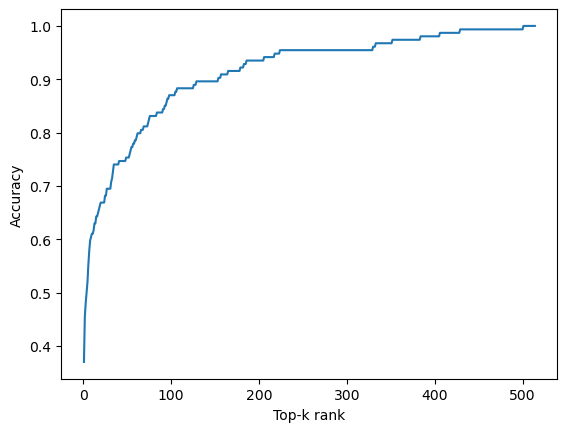

In [32]:
# Probe images to test against the embedding gallery
with torch.inference_mode():
    models.eval()
    correct_counts = [0.0] * len(gallery_set["label"])
    total_counts = [0.0] * len(gallery_set["label"])
    top_k_accuracy = [0.0] * len(gallery_set["label"])

    for probe_idx in range(len(query_set['embedding'])):
        probe_emb = query_set['embedding'][probe_idx]
        probe_label = query_set['label'][probe_idx]
        cos_similarity = F.cosine_similarity(probe_emb, gallery_set['embedding'], dim= -1)

        # Iterate over all values of k
        for k in range(1, len(gallery_set["label"])+1):
            ret, pred = torch.topk(cos_similarity, k)

            # Compute accuracy for this value of k
            correct_counts[k-1] += int(any(probe_label == gallery_set['label'][i] for i in pred.to("cpu").numpy().tolist()[:k]))
            total_counts[k-1] += 1
            top_k_accuracy[k-1] = correct_counts[k-1] / total_counts[k-1]

# Plot the accuracy vs top-k rank
import matplotlib.pyplot as plt
plt.plot(range(1, len(top_k_accuracy)+1), top_k_accuracy)
plt.xlabel('Top-k rank')
plt.ylabel('Accuracy')
plt.show()

In [33]:
# Face Verification 
from deepface import DeepFace
correct_counts = 0.0
for idx, (img1, img2) in enumerate(lfw_pairs_test.data):
    obj = DeepFace.verify(img1, img2
          , model_name = 'ArcFace', detector_backend = 'retinaface')
    _, _, label = lfw_pairs_test[idx]
    correct_counts += (label == 1) == obj['verified']
    print('Cosine Similarity: {}, Prediction: {}, Label: {}'.format(1 - obj['distance'], obj['verified'], label == 1))
print(correct_counts / len(lfw_pairs_test.data))

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 143MB/s]


arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:01<00:00, 136MB/s]


Cosine Similarity: 0.7500081590795741, Prediction: True, Label: True
Cosine Similarity: 0.4988816461887202, Prediction: True, Label: True
Cosine Similarity: 0.391444697944783, Prediction: True, Label: True
Cosine Similarity: 0.7199018367373645, Prediction: True, Label: True
Cosine Similarity: 0.5619132511442005, Prediction: True, Label: True
Cosine Similarity: 0.6115510932641096, Prediction: True, Label: True
Cosine Similarity: 0.69758102231712, Prediction: True, Label: True
Cosine Similarity: 0.5097199257849031, Prediction: True, Label: True
Cosine Similarity: 0.7243355862082275, Prediction: True, Label: True
Cosine Similarity: 0.6263054989116711, Prediction: True, Label: True
Cosine Similarity: 0.7157036199019519, Prediction: True, Label: True
Cosine Similarity: 0.5985647680798739, Prediction: True, Label: True
Cosine Similarity: 0.5935815287972948, Prediction: True, Label: True
Cosine Similarity: 0.44945125953497667, Prediction: True, Label: True
Cosine Similarity: 0.563119533779872

torch.Size([3, 112, 112])
torch.Size([3, 112, 112])


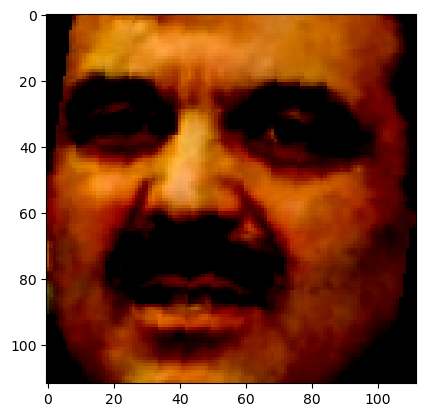

In [34]:
img1_path, img2_path = lfw_pairs_test.data[0]
img1 = RetinaFace.extract_faces(img1_path, align= True)
img2 = RetinaFace.extract_faces(img2_path, align= True)
img1 = Image.fromarray(img1[0])
img2 = Image.fromarray(img2[0])
img1 = img1.convert("RGB")
img2 = img2.convert("RGB")
img1 = transform(img1)
img2 = transform(img2)
img1_ex, label = lfwdataset_test[0]
print(img1_ex.shape)
print(img1.shape)
plt.imshow(img1.permute(1,2,0))

In [35]:
# Evaluate against my model 
with torch.inference_mode():
    correct_count = 0.0
    models.eval()
    for idx, (img1, img2, label) in enumerate(lfw_pairs_test):
        
        # Do Face Detection Alignment
        img1_path, img2_path = lfw_pairs_test.data[idx]
        img1 = RetinaFace.extract_faces(img1_path, align= True)
        img2 = RetinaFace.extract_faces(img2_path, align= True)
        img1 = Image.fromarray(img1[0])
        img2 = Image.fromarray(img2[0])
        img1 = img1.convert("RGB")
        img2 = img2.convert("RGB")
        img1 = transform(img1)
        img2 = transform(img2)
        
        # Convert images to cuda
        img1, img2 = img1.to(device), img2.to(device)
        img1 = torch.unsqueeze(img1, dim= 0)
        img2 = torch.unsqueeze(img2, dim= 0)
        #print(img1.shape)
        embed_1 = models(img1)
        embed_2 = models(img2)
        cos_sim = F.cosine_similarity(embed_1, embed_2)
        print('Cosine Similarity: {}, Prediction: {}, Ground Truth: {}'.format(cos_sim.to("cpu").numpy()[0], cos_sim.to("cpu").numpy()[0] > 0.5, label))
        correct_counts += label == (cos_sim.to("cpu").numpy()[0] > 0.5)
    print(correct_count / len(lfw_pairs_test))

Cosine Similarity: 0.5137472748756409, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.0761970654129982, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.47418689727783203, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.5675563812255859, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.3252423107624054, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.42900124192237854, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.4557557702064514, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.1874641478061676, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.3840210437774658, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.3363678455352783, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.6923305988311768, Prediction: True, Ground Truth: 1
Cosine Similarity: 0.17052802443504333, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.19755053520202637, Prediction: False, Ground Truth: 1
Cosine Similarity: 0.2458705753087997

In [36]:
# Inference Testing
with torch.no_grad():
        print("Run Testing Set:")
        # Set to evaluation mode
        models.eval()

        test_loss = 0.0
        test_acc = 0.0

        for j, (images, labels) in enumerate(data_loader_test):
            # Put tensors into device to run CUDA
            images, labels = images.to(device), labels.to(device)

            # Run Resnet50 on images to compute the output feature
            embeddings = models(images)

            # Push this embedding to our Arcface fc output layer
            output = metric_fc(embeddings)
            
            # Calculate loss
            loss = Loss(output, labels)

            # Calculate the total loss for the batch and add it to valid_loss
            test_loss += loss.item()

            # Accuracy prediction
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute the total accuracy in the whole batch and add to train_acc
            test_acc += acc.item()
            if (j % 5 == 0):
              print('Validation Batch #: {:03d}, Train Loss: {}, Accuracy: {}'
              .format(j+1, test_loss / (j + 1), test_acc / (j + 1)))


Run Testing Set:
Validation Batch #: 001, Train Loss: 8.663949966430664, Accuracy: 0.0
Validation Batch #: 006, Train Loss: 8.661351998647055, Accuracy: 0.0
Validation Batch #: 011, Train Loss: 8.664247512817383, Accuracy: 0.0
Validation Batch #: 016, Train Loss: 8.657996833324432, Accuracy: 0.0
Validation Batch #: 021, Train Loss: 8.658361616588774, Accuracy: 0.0
Validation Batch #: 026, Train Loss: 8.657218749706562, Accuracy: 0.0
Validation Batch #: 031, Train Loss: 8.654943281604398, Accuracy: 0.0
